<a href="https://colab.research.google.com/github/bofeng2268/qm2/blob/main/analysis_plot_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
!pip install seaborn
!pip install matplotlib
!pip install esda
!pip install Pillow
!pip install geopandas libpysal mgwr

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np

In [110]:
#from example
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from statsmodels.formula.api import ols
from esda.moran import Moran
from libpysal.weights import Queen
import geopandas as gpd
import requests
import json
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col
import libpysal as ps
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

# Merging and Cleaning Data

In [111]:
#FILE PATHS
csv_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv'
topojson_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/topo_lad.json'
local_authorities_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/download6923730533685635445.csv'


In [112]:
#prepare the dataset for total disabled people density by regions
#link source:
total=pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv')
eng_disability_data = total[total['Lower tier local authorities Code'].str.startswith('E')]
filtered_disability_data = eng_disability_data[eng_disability_data['Disability (5 categories) Code'].isin([1, 2])]
disabled = filtered_disability_data.groupby('Lower tier local authorities')['Observation'].sum().reset_index()


In [113]:
print(disabled)

    Lower tier local authorities  Observation
0                           Adur        12577
1                      Allerdale        19205
2                   Amber Valley        25066
3                           Arun        32481
4                       Ashfield        27809
..                           ...          ...
304                     Worthing        21303
305                     Wychavon        22955
306                         Wyre        24771
307                  Wyre Forest        20459
308                         York        34592

[309 rows x 2 columns]


Renaming changes that have to be turned into _____

Bristol --> Bristol, City of

Herefordshire --> Herefordshire, County of

Kingston upon Hull --> Kingston upon Hull, City of

North Northamptonshire --> East Northamptonshire

West Northamptonshire --> South Northamptonshire

In [114]:

rename_map = {
    'Bristol': 'Bristol, City of',
    'Herefordshire': 'Herefordshire, County of',
    'Kingston upon Hull': 'Kingston upon Hull, City of',
    'North Northamptonshire': 'East Northamptonshire',
    'West Northamptonshire': 'South Northamptonshire'
}

disabled['Lower tier local authorities'] = disabled['Lower tier local authorities'].map(rename_map).fillna(disabled['Lower tier local authorities'])
print(disabled)

    Lower tier local authorities  Observation
0                           Adur        12577
1                      Allerdale        19205
2                   Amber Valley        25066
3                           Arun        32481
4                       Ashfield        27809
..                           ...          ...
304                     Worthing        21303
305                     Wychavon        22955
306                         Wyre        24771
307                  Wyre Forest        20459
308                         York        34592

[309 rows x 2 columns]


In [115]:
#prepare the blue badged population by regions
blue_badge = pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/Blue_badges_held.csv', delimiter=';')
blue_badges_narrowed =  blue_badge[['Local Authority', 'Total valid Blue Badges held by organisations and individuals']]
filtered_blue_badges = blue_badges_narrowed[~blue_badges_narrowed['Local Authority'].str.contains('All')]

filtered_blue_badges


,Local Authority,Total valid Blue Badges held by organisations and individuals
2,County Durham,27.884
3,Darlington,5.945
4,Hartlepool,5.530
5,Middlesbrough,6.546
6,Northumberland,16.242
...,...,...
163,Wiltshire,23.267
164,Devon,41.387
165,Dorset,25.370
166,Gloucestershire,28.348


In [116]:
rename_map2 = {
    'Brent': 'Brentwood',
    'North Northamptonshire': 'East Northamptonshire',
    'West Northamptonshire': 'South Northamptonshire',
    'Cambridgeshire': 'East Cambridgeshire',
    'Hampshire': 'East Hampshire',
    'Derbyshire': 'Derbyshire Dales',
    'Lancashire': 'West Lancashire',
    'Lincolnshire': 'Lincoln',
    'Somerset': 'South Somerset',
    'Surrey': 'Surrey Heath',
    'Warwickshire': 'North Warwickshire',
    'Leicestershire': 'North West Leicestershire'
}

filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].map(rename_map2).fillna(filtered_blue_badges['Local Authority'])

<ipython-input-116-8bab8b6f5c03>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].map(rename_map2).fillna(filtered_blue_badges['Local Authority'])


In [117]:
filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'], errors='coerce')

# You may want to handle NaN values here, either by filling with a default value or dropping those rows
# For example, to drop rows with NaN values, uncomment the following line:
# filtered_blue_badges.dropna(subset=['Total valid Blue Badges held by organisations and individuals'], inplace=True)

# Now, multiply by 1000 and convert to integer
filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = (filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] * 1000).astype(int)

filtered_blue_badges

<ipython-input-117-52c0b4b495e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'], errors='coerce')
<ipython-input-117-52c0b4b495e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = (filtered_blue_badges['Total valid Blue Badges held by

,Local Authority,Total valid Blue Badges held by organisations and individuals
2,County Durham,27884
3,Darlington,5945
4,Hartlepool,5530
5,Middlesbrough,6546
6,Northumberland,16242
...,...,...
163,Wiltshire,23267
164,Devon,41387
165,Dorset,25370
166,Gloucestershire,28348


Take the 'Essex' datapoint from column 'Local Authority' and rename it as 'Braintree'
Take its corresponding value from the "Total valid Blue Badges held by organisations and individuals" column and divide the number by 8

Add new datapoints to the data frame: here put in order as 'Local Authority', 'Total valid Blue Badges held by organisations and individuals'
Castle Point, Same value as 'Braintree's new value (once it has been divided by 8)
Chelmsford, Same value as 'Braintree's new value (once it has been divided by 8)
Colchester, Same value as 'Braintree's new value (once it has been divided by 8)
Harlow, Same value as 'Braintree's new value (once it has been divided by 8)
Maldon, Same value as 'Braintree's new value (once it has been divided by 8)
Rochford, Same value as 'Braintree's new value (once it has been divided by 8)
Uttlesford, Same value as 'Braintree's new value (once it has been divided by 8)

The modifications have been successfully applied to the dataset. The 'Essex' datapoint in the 'Local Authority' column has been renamed to 'Braintree', and its corresponding value in the "Total valid Blue Badges held by organisations and individuals" column was divided by 8, resulting in a value of 7,728.875.

In [138]:
# Check if 'Essex' exists in the data, if not, 'Essex_value_divided' remains None
if 'Essex' in filtered_blue_badges['Local Authority'].values:
    essex_value_divided = filtered_blue_badges[filtered_blue_badges['Local Authority'] == 'Essex']['Total valid Blue Badges held by organisations and individuals'].iloc[0] / 8
else:
    essex_value_divided = None

# Append new rows only if 'Essex_value_divided' is not None and the local authorities are not already in the dataframe
new_local_authorities = ['Castle Point', 'Chelmsford', 'Colchester', 'Harlow', 'Maldon', 'Rochford', 'Uttlesford']
for la in new_local_authorities:
    if la not in filtered_blue_badges['Local Authority'].values and essex_value_divided is not None:
        new_row = {'Local Authority': la,
                   'Total valid Blue Badges held by organisations and individuals': essex_value_divided}
        filtered_blue_badges = filtered_blue_badges.append(new_row, ignore_index=True)

# Display the last few rows and the total number of rows in 'filtered_blue_badges'
total_rows_after_correction = filtered_blue_badges.shape[0]
filtered_blue_badges.tail(10), total_rows_after_correction

# Renaming 'Norfolk' to 'King's Lynn and West Norfolk' in the 'Local Authority' column
norfolk_row = filtered_blue_badges[filtered_blue_badges['Local Authority'] == 'Norfolk']
if not norfolk_row.empty:
    norfolk_index = norfolk_row.index[0]
    filtered_blue_badges.at[norfolk_index, 'Local Authority'] = "King's Lynn and West Norfolk"

    # Dividing the corresponding value by 3
    norfolk_value = norfolk_row.iloc[0]['Total valid Blue Badges held by organisations and individuals']
    norfolk_value_divided = norfolk_value / 3

    # Adding new datapoints for 'South Norfolk' and 'North Norfolk' with the modified value
    new_local_authorities_norfolk = ['South Norfolk', 'North Norfolk']
    for la in new_local_authorities_norfolk:
        if la not in filtered_blue_badges['Local Authority'].values:
            new_row = {'Local Authority': la,
                       'Total valid Blue Badges held by organisations and individuals': norfolk_value_divided}
            filtered_blue_badges = filtered_blue_badges.append(new_row, ignore_index=True)
else:
    norfolk_value_divided = None

# Display the last few rows and the total number of rows in 'filtered_blue_badges'
total_rows_after_norfolk_update = filtered_blue_badges.shape[0]
filtered_blue_badges.tail(10), total_rows_after_norfolk_update

# Renaming 'Oxfordshire' to 'South Oxfordshire' in the 'Local Authority' column
oxfordshire_row = filtered_blue_badges[filtered_blue_badges['Local Authority'] == 'Oxfordshire']
if not oxfordshire_row.empty:
    oxfordshire_index = oxfordshire_row.index[0]
    filtered_blue_badges.at[oxfordshire_index, 'Local Authority'] = 'South Oxfordshire'

    # Dividing the corresponding value by 2
    oxfordshire_value = oxfordshire_row.iloc[0]['Total valid Blue Badges held by organisations and individuals']
    oxfordshire_value_divided = oxfordshire_value / 2

    # Adding a new datapoint for 'West Oxfordshire' with the modified value
    if 'West Oxfordshire' not in filtered_blue_badges['Local Authority'].values:
        new_row = {'Local Authority': 'West Oxfordshire',
                   'Total valid Blue Badges held by organisations and individuals': oxfordshire_value_divided}
        filtered_blue_badges = filtered_blue_badges.append(new_row, ignore_index=True)
else:
    oxfordshire_value_divided = None

# Display the last few rows and the total number of rows in 'filtered_blue_badges'
total_rows_after_oxfordshire_update = filtered_blue_badges.shape[0]
filtered_blue_badges.tail(10), total_rows_after_oxfordshire_update

filtered_blue_badges

,Local Authority,Total valid Blue Badges held by organisations and individuals
0,County Durham,27884.000
1,Darlington,5945.000
2,Hartlepool,5530.000
3,Middlesbrough,6546.000
4,Northumberland,16242.000
...,...,...
160,Colchester,7728.875
161,Harlow,7728.875
162,Maldon,7728.875
163,Rochford,7728.875


In [122]:
#merge the two datasets
merged_data = pd.merge(filtered_blue_badges, disabled, left_on='Local Authority', right_on='Lower tier local authorities', how='inner')


# Convert columns to numeric
merged_data['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(merged_data['Total valid Blue Badges held by organisations and individuals'])
merged_data['Observation'] = pd.to_numeric(merged_data['Observation'])
merged_data

,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation
0,County Durham,27884.000,County Durham,119790
1,Darlington,5945.000,Darlington,21104
2,Hartlepool,5530.000,Hartlepool,21145
3,Middlesbrough,6546.000,Middlesbrough,29520
4,Northumberland,16242.000,Northumberland,67190
...,...,...,...,...
119,Colchester,7728.875,Colchester,32624
120,Harlow,7728.875,Harlow,15224
121,Maldon,7728.875,Maldon,11484
122,Rochford,7728.875,Rochford,13697


## WE ARE MISSING LOCAL AUTHORITIES HERE

In [123]:

# List of 32 London local authorities
london_authorities = [
    "City of London", "City of Westminster", "Kensington and Chelsea",
    "Hammersmith and Fulham", "Wandsworth", "Lambeth", "Southwark",
    "Tower Hamlets", "Hackney", "Islington", "Camden", "Brent", "Ealing",
    "Hounslow", "Richmond upon Thames", "Kingston upon Thames", "Merton",
    "Sutton", "Croydon", "Bromley", "Lewisham", "Greenwich", "Bexley",
    "Havering", "Barking and Dagenham", "Redbridge", "Newham",
    "Waltham Forest", "Haringey", "Enfield", "Barnet", "Harrow", "Hillingdon"
]

# Filter the DataFrame to include only rows where 'Local Authority' matches the London authorities
london_data = merged_data[merged_data['Local Authority'].isin(london_authorities)]

# Display the filtered DataFrame
london_data


,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation
63,Camden,6495.0,Camden,31882
64,City of London,146000.0,City of London,919
65,Haringey,8230.0,Haringey,36114
66,Islington,7730.0,Islington,35063
67,Kensington and Chelsea,2442.0,Kensington and Chelsea,18311
68,Southwark,6720.0,Southwark,42022
69,Tower Hamlets,7108.0,Tower Hamlets,40125
70,Wandsworth,6612.0,Wandsworth,37444
72,Barking and Dagenham,7519.0,Barking and Dagenham,28993
73,Barnet,15231.0,Barnet,49679


⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕  WHY IS 'City of London' containing only 919 observations?
i am now creating a dataframe exlcuding outliers - such as this one.

In [124]:
#OUTLIERS for 'Observation' (deleting City of London Outlier)

# Calculate Q1, Q3, and IQR
Q1 = london_data['Observation'].quantile(0.25)
Q3 = london_data['Observation'].quantile(0.75)
IQR = Q3 - Q1

# Define the range for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
london_data_no_outliers = london_data[(london_data['Observation'] >= lower_bound) & (london_data['Observation'] <= upper_bound)]

london_data_no_outliers

,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation
63,Camden,6495.0,Camden,31882
65,Haringey,8230.0,Haringey,36114
66,Islington,7730.0,Islington,35063
67,Kensington and Chelsea,2442.0,Kensington and Chelsea,18311
68,Southwark,6720.0,Southwark,42022
69,Tower Hamlets,7108.0,Tower Hamlets,40125
70,Wandsworth,6612.0,Wandsworth,37444
72,Barking and Dagenham,7519.0,Barking and Dagenham,28993
73,Barnet,15231.0,Barnet,49679
74,Bexley,9451.0,Bexley,36083


# **1. Summary Statistics**

In [125]:
reg_df= london_data_no_outliers.drop(['Lower tier local authorities'],axis=1)
reg_df['Local Authority']=reg_df['Local Authority'].astype('category')
reg_df.rename(columns={'Observation': 'Disable_population'}, inplace=True)
reg_df.rename(columns={'Total valid Blue Badges held by organisations and individuals': 'Blue_Badges_population'}, inplace=True)
reg_df

,Local Authority,Blue_Badges_population,Disable_population
63,Camden,6495.0,31882
65,Haringey,8230.0,36114
66,Islington,7730.0,35063
67,Kensington and Chelsea,2442.0,18311
68,Southwark,6720.0,42022
69,Tower Hamlets,7108.0,40125
70,Wandsworth,6612.0,37444
72,Barking and Dagenham,7519.0,28993
73,Barnet,15231.0,49679
74,Bexley,9451.0,36083


In [126]:
summary=reg_df.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary

,count,mean,std,min,25%,50%,75%,max
Blue_Badges_population,25.0,8413.04,2875.77,2442.0,6720.0,7730.0,10657.0,15231.0
Disable_population,25.0,36278.44,8659.34,18311.0,31258.0,36762.0,41576.0,54852.0


# **2. Visualization**
no need for that

# **3. Assumptions**

Text(87.72222222222221, 0.5, 'Blue Badges population')

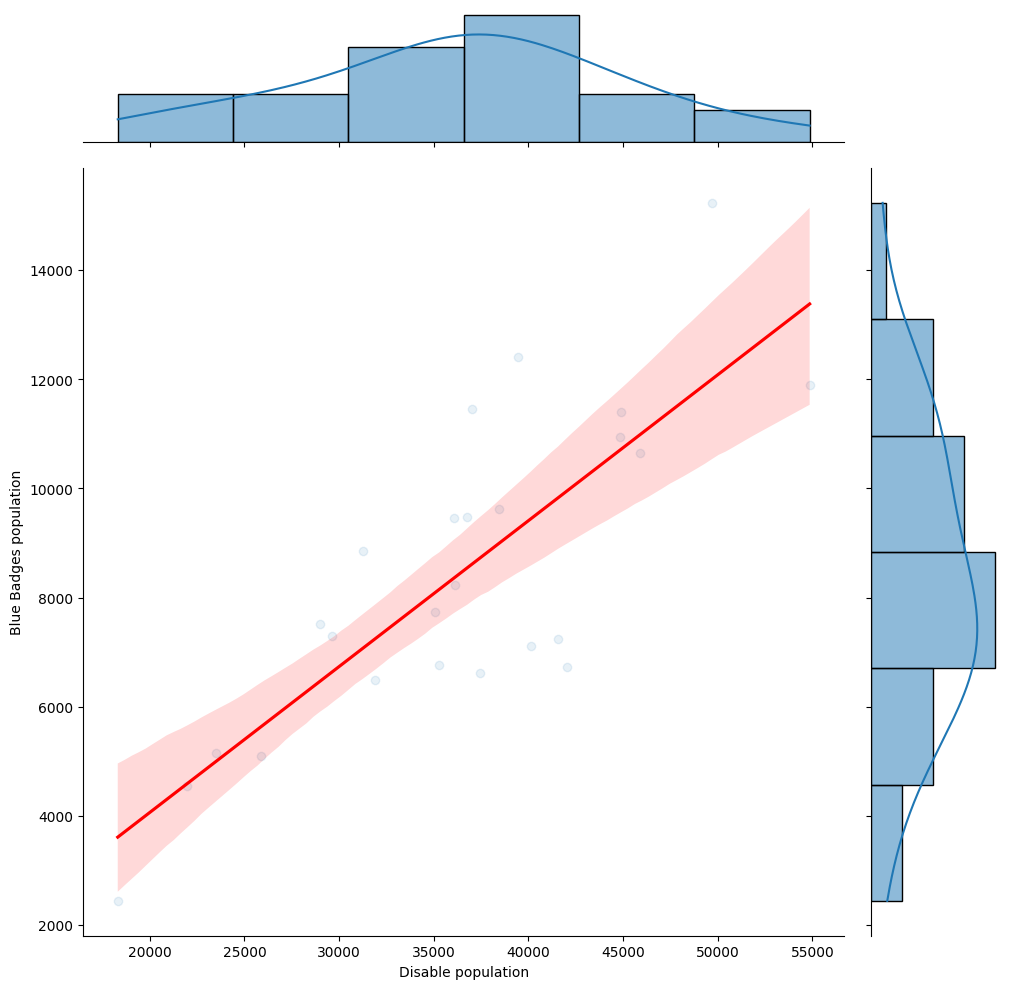

In [127]:
#Homoscedasticity
sns.jointplot(data=reg_df, # plot a scatterplot with a regression line and two histograms
                x='Disable_population', # set the x axis to be the years of schooling
                y='Blue_Badges_population', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Disable population') # add a label to the x axis
plt.ylabel('Blue Badges population') # add a label to the y axis

# **4. Regression**

In [128]:
from statsmodels.formula.api import ols #the function
from statsmodels.iolib.summary2 import summary_col #to produce a very nice table

model= ols('Blue_Badges_population ~  Disable_population', data=reg_df).fit() # fit the model
print(model.summary()) # print the summary

                              OLS Regression Results                              
Dep. Variable:     Blue_Badges_population   R-squared:                       0.648
Model:                                OLS   Adj. R-squared:                  0.633
Method:                     Least Squares   F-statistic:                     42.38
Date:                    Fri, 12 Jan 2024   Prob (F-statistic):           1.21e-06
Time:                            02:12:41   Log-Likelihood:                -221.01
No. Observations:                      25   AIC:                             446.0
Df Residuals:                          23   BIC:                             448.4
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕***WE HAVE TO REWRITE THE WHOLE OF THIS BECAUSE IT IS NOT APPLIED TO THE NEW LONDON FOCUSED CODE***. ⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕⭕

1.The R-squared of 0.033 sugested that **only 3.3%% of the variation in blue badges population can be explained by the total disabled population**, imples that there could be more varables(loneliness, spread of transportation and accessibility of transportation and etc.) that affecting the blue badges population.

2.The coefficient of 0.0001 means **10000 unit increase in total diabled population will lead to 1 unit increase in blue badges population**


3.The p-value of 0.004 is less that 0.05, suggests that the coefficient is statistically significant at the 5% level and **we can reject the null hypothesis.**

# Transport Reliant Disabled People

In [129]:
# Convert columns to numeric
london_data_no_outliers['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric( london_data_no_outliers['Total valid Blue Badges held by organisations and individuals'])
london_data_no_outliers['Observation'] = pd.to_numeric( london_data_no_outliers['Observation'])

# Create the new column by subtracting the two columns
london_data_no_outliers['Transport reliant people with a disability estimate'] =  london_data_no_outliers['Observation'] -  london_data_no_outliers['Total valid Blue Badges held by organisations and individuals']
London_TR_data =  london_data_no_outliers

# Display the DataFrame
London_TR_data

<ipython-input-129-bfff857647d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_data_no_outliers['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric( london_data_no_outliers['Total valid Blue Badges held by organisations and individuals'])
<ipython-input-129-bfff857647d0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  london_data_no_outliers['Observation'] = pd.to_numeric( london_data_no_outliers['Observation'])
<ipython-input-129-bfff857647d0>:6: SettingWithCopyWarni

,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation,Transport reliant people with a disability estimate
63,Camden,6495.0,Camden,31882,25387.0
65,Haringey,8230.0,Haringey,36114,27884.0
66,Islington,7730.0,Islington,35063,27333.0
67,Kensington and Chelsea,2442.0,Kensington and Chelsea,18311,15869.0
68,Southwark,6720.0,Southwark,42022,35302.0
69,Tower Hamlets,7108.0,Tower Hamlets,40125,33017.0
70,Wandsworth,6612.0,Wandsworth,37444,30832.0
72,Barking and Dagenham,7519.0,Barking and Dagenham,28993,21474.0
73,Barnet,15231.0,Barnet,49679,34448.0
74,Bexley,9451.0,Bexley,36083,26632.0


# Summary Statistics TRP

In [130]:
reg_df2= London_TR_data.drop(['Lower tier local authorities'],axis=1)
reg_df2 = reg_df2.drop('Total valid Blue Badges held by organisations and individuals', axis=1)

reg_df2['Local Authority']=reg_df['Local Authority'].astype('category')
reg_df2.rename(columns={'Observation': 'Disable_population'}, inplace=True)
reg_df2.rename(columns={'Transport reliant people with a disability estimate': 'Transport_Reliant_Disabled_population'}, inplace=True)

reg_df2

,Local Authority,Disable_population,Transport_Reliant_Disabled_population
63,Camden,31882,25387.0
65,Haringey,36114,27884.0
66,Islington,35063,27333.0
67,Kensington and Chelsea,18311,15869.0
68,Southwark,42022,35302.0
69,Tower Hamlets,40125,33017.0
70,Wandsworth,37444,30832.0
72,Barking and Dagenham,28993,21474.0
73,Barnet,49679,34448.0
74,Bexley,36083,26632.0


In [131]:
summary=reg_df2.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary

,count,mean,std,min,25%,50%,75%,max
Disable_population,25.0,36278.44,8659.34,18311.0,31258.0,36762.0,41576.0,54852.0
Transport_Reliant_Disabled_population,25.0,27865.40,6569.26,15869.0,22408.0,27333.0,33479.0,42952.0


In [132]:
#SHOULD WE STILL DO OUTLIERS HERE?

# Assumptions

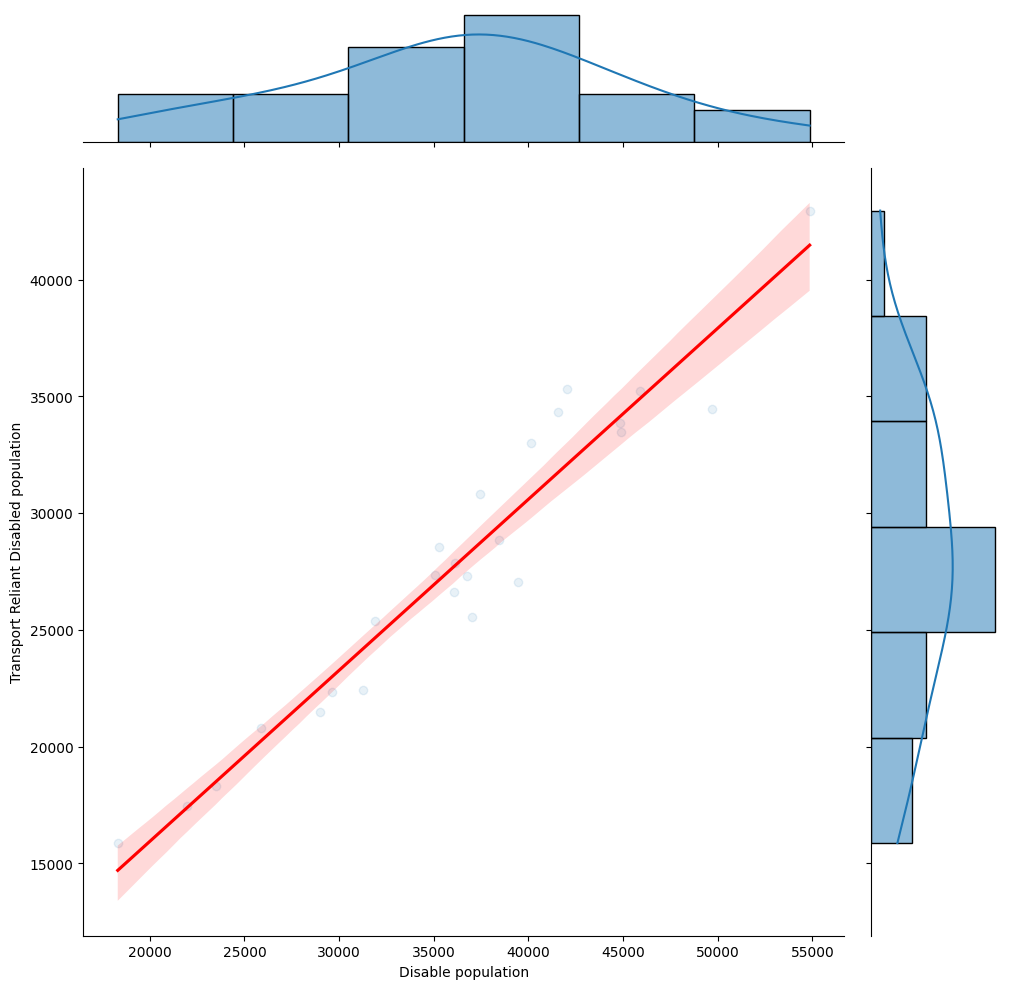

In [133]:
# Homoscedasticity
sns.jointplot(data=reg_df2,
              x='Disable_population',
              y='Transport_Reliant_Disabled_population', # Corrected the column name here
              kind="reg",
              scatter_kws=dict(alpha=0.1),
              line_kws=dict(color='red'),
              height=10)

plt.xlabel('Disable population')
plt.ylabel('Transport Reliant Disabled population') # Corrected the label here (optional: match the actual column name)

plt.show()  # To display the plot